# 1.Library

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from scipy import stats
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


# 2.Read data from csv file

In [2]:
def clean(features, data):
    choose = np.array([True] * len(data))
    for feature in features:
        z_score = stats.zscore(data[feature])
        z_score = np.abs(z_score) < 3
        choose = choose & z_score
    data_clean = data[choose]
    return data_clean

In [3]:
df = pd.read_csv('data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by=['row', 'col'], ascending=[True, True]).reset_index(drop=True)
features = [
    'AWS2', 'CAPE', 'V850', 'EWSS', 'KX', 'U250', 'U850', 'CIN', 'V250', 'R250',
    'hour_sin','hour_cos','doy_sin','doy_cos'
]
target = 'AWS'
df['AWS2'] = df['AWS']

df = clean(features[0:10],df)

df['year'] = df['datetime'].dt.year
df['hour']     = df['datetime'].dt.hour
df['doy']      = df['datetime'].dt.dayofyear
df['hour_sin'] = np.sin(2*np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2*np.pi * df['hour'] / 24)
df['doy_sin']  = np.sin(2*np.pi * df['doy']  / 365)
df['doy_cos']  = np.cos(2*np.pi * df['doy']  / 365)


dftrain = df[df['datetime'] <= pd.Timestamp('2020-10-15 23:00:00')].reset_index(drop=True)
dftest = df[df['datetime'] >= pd.Timestamp('2020-10-16 00:00:00')].reset_index(drop=True)
print(len(df))
scaler_f = StandardScaler()
dftrain[features] = scaler_f.fit_transform(dftrain[features])
dftest[features] = scaler_f.fit_transform(dftest[features])
dftest.head()

600608


,row,col,datetime,AWS,CAPE,CIN,EWSS,IE,ISOR,KX,...,V250,V850,AWS2,year,hour,doy,hour_sin,hour_cos,doy_sin,doy_cos
0,0,104,2020-10-16 00:00:00,1.4,-0.001707,0.191219,0.024895,-0.000008,0.676296,0.865026,...,0.764970,0.838088,1.329167,2020,0,290,-0.015190,1.440072,-1.464404,-1.659748
1,0,104,2020-10-16 01:00:00,1.4,0.093297,0.191219,0.004356,-0.000014,0.676296,0.743127,...,0.638921,0.736950,1.329167,2020,1,290,0.351498,1.391947,-1.464404,-1.659748
2,0,104,2020-10-16 02:00:00,0.0,0.269404,0.191219,-0.047775,-0.000025,0.676296,0.644408,...,0.624177,0.522088,-0.323436,2020,2,290,0.693197,1.250850,-1.464404,-1.659748
3,0,104,2020-10-16 03:00:00,0.0,0.489537,0.191219,-0.113967,-0.000034,0.676296,0.593042,...,0.739784,0.283018,-0.323436,2020,3,290,0.986620,1.026398,-1.464404,-1.659748
4,0,104,2020-10-16 04:00:00,0.0,0.433924,0.191219,-0.068335,-0.000047,0.676296,0.542930,...,0.837368,0.166977,-0.323436,2020,4,290,1.211772,0.733887,-1.464404,-1.659748


In [4]:
scaler_f = StandardScaler()
dftrain[features] = scaler_f.fit_transform(dftrain[features])
dftest[features] = scaler_f.transform(dftest[features])

In [5]:
def make_sequences(data, feats, tgt, window_size, horizon):
    X, y = [], []
    arr_f = data[feats].values
    arr_t = data[tgt].values
    time = data['datetime'].tolist()
    for i in range(window_size, len(data)-horizon+1):
        check = False
        for j in range(i-window_size+1, i+horizon):
            if (time[j] - time[j-1]).total_seconds() != 3600:
                check = True
                break
        if check:
            continue
        X.append(arr_f[i-window_size:i])
        y.append(arr_t[i:i+horizon])
    return np.array(X), np.array(y)


In [6]:
window_size = 1
horizon     = 6

X_train, y_train = make_sequences(dftrain, features, target, window_size, horizon)
X_test, y_test = make_sequences(dftest, features, target, window_size, horizon)
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)


Train shapes: (351315, 1, 14) (351315, 6)
Test shapes: (74038, 1, 14) (74038, 6)


In [7]:
def model_eval(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)
    mae = mean_absolute_error(y_test,y_pred)
    print("Mean Absolute Error:", mae)
    r2 = r2_score(y_test,y_pred)
    print("R-squared:", r2)
    corr, p = stats.pearsonr(y_test.reshape(-1), y_pred.reshape(-1))
    print("Pearson Correlation Coefficient:", corr)

# 3.Models

## 3.1 Lasso

In [11]:
print(X_train.shape, y_train.shape)
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
model_eval(y_test, y_pred)

(351315, 10) (351315, 6)
Mean Squared Error: 0.3915351649551406
Mean Absolute Error: 0.215439245934023
R-squared: 0.12962311782381658
Pearson Correlation Coefficient: 0.5690603965054294


## 3.2 ridge

In [20]:
print(X_train.shape, y_train.shape)
ridge = Ridge(alpha=0.01)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
model_eval(y_test, y_pred)

(351315, 10) (351315, 6)
Mean Squared Error: 0.38207704587353963
Mean Absolute Error: 0.22656074604724866
R-squared: 0.1505312622989584
Pearson Correlation Coefficient: 0.5543518168846732


## 3.3 random forest

### 3.3.1 Default random forest

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
model_eval(y_test, y_pred)

Mean Squared Error: 0.34827805836328984
Mean Absolute Error: 0.21762216059543926
R-squared: 0.22502570192943225
Pearson Correlation Coefficient: 0.5161403212496837


### 3.3.2 Random forest with random search cv

In [34]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
param_dist = {
    'max_depth': [7, 8, 9, 10, 11],
    'n_estimators': [100, 125, 150, 175, 200],
    'min_samples_leaf': [1, 2, 3, 4, 5], 
    'bootstrap': [True],
}

random_search = RandomizedSearchCV(
    rf, 
    param_distributions=param_dist, 
    n_iter= 10,
    scoring='neg_mean_squared_error',
    cv=3, 
    verbose=2, 
    random_state=42,
)

In [35]:
random_search.fit(X_train, y_train)
best_params = random_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=7, min_samples_leaf=4, n_estimators=175; total time= 4.0min
[CV] END bootstrap=True, max_depth=7, min_samples_leaf=4, n_estimators=175; total time= 3.9min
[CV] END bootstrap=True, max_depth=7, min_samples_leaf=4, n_estimators=175; total time= 3.7min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=4, n_estimators=150; total time= 3.7min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=4, n_estimators=150; total time= 3.9min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=4, n_estimators=150; total time= 3.7min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=3, n_estimators=125; total time= 3.3min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=3, n_estimators=125; total time= 3.3min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=3, n_estimators=125; total time= 3.2min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, n_estimators=125; total t

In [36]:
print(best_params)

{'n_estimators': 175, 'min_samples_leaf': 5, 'max_depth': 11, 'bootstrap': True}


In [37]:
rf = RandomForestRegressor(**best_params, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
model_eval(y_test, y_pred)

Mean Squared Error: 0.3489252997749654
Mean Absolute Error: 0.21917975182455415
R-squared: 0.22368996555245882
Pearson Correlation Coefficient: 0.517322715996719


## 3.4.XGboost

### 3.4.1 Default XGboost

In [8]:
X_train = X_train[:,:,0:10].reshape(-1,10)
X_test = X_test[:,:,0:10].reshape(-1,10)
print(X_train.shape, X_test.shape)

(351315, 10) (74038, 10)


In [9]:
xgbr_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth = 7, random_state=42)

In [10]:
xgbr_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [11]:
y_pred = xgbr_model.predict(X_test.reshape(-1,10))
load_model = xgbr_model
model_eval(y_test, y_pred)

Mean Squared Error: 0.5281791707285959
Mean Absolute Error: 0.35813282591254997
R-squared: -0.1738150954546623
Pearson Correlation Coefficient: 0.2582601573232989


### 3.4.2 Bayesian Optimization

In [137]:
# X_train = X_train[:,:,0:10].reshape(-1,10)
# X_test = X_test[:,:,0:10].reshape(-1,10)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(351227, 10) (351227, 6)
(72814, 10) (72814, 6)


In [12]:
# def xgb_eval(n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight):
def xgb_eval(n_estimators, max_depth, learning_rate):
    model = xgb.XGBRegressor(
        objective='reg:squarederror', 
            n_estimators = int(n_estimators), 
            max_depth = int(max_depth),
            random_state = 42,
            learning_rate = learning_rate,
            # subsample = subsample,
            # colsample_bytree = colsample_bytree,
            # min_child_weight = int(min_child_weight)
    )
    
    score = cross_val_score(model, X_train, y_train, cv = 3, scoring='neg_mean_squared_error')
    return np.mean(score)

params_bounds = {
    'max_depth': (5, 10),
    'n_estimators': (100, 300),
    'learning_rate': (0.1, 0.3),
    # 'subsample': (0.6, 1.0),
    # 'colsample_bytree': (0.6, 1.0),
    # 'min_child_weight': (1, 5),
}

bayes_opt = BayesianOptimization(
    f=xgb_eval,
    pbounds=params_bounds,
    random_state=42,
    verbose=2,
)

bayes_opt.maximize(init_points=3, n_iter=10)

best_params = bayes_opt.max['params']
print("Best parameters:", best_params)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | -0.1932   | 0.1749    | 9.754     | 246.4     |
| 2         | -0.1765   | 0.2197    | 5.78      | 131.2     |
| 3         | -0.1828   | 0.1116    | 9.331     | 220.2     |
| 4         | -0.1724   | 0.2382    | 5.107     | 130.2     |
| 5         | -0.1679   | 0.1848    | 5.034     | 126.7     |
| 6         | -0.1682   | 0.1729    | 5.435     | 119.3     |
| 7         | -0.1959   | 0.2701    | 9.814     | 112.4     |
| 8         | -0.1981   | 0.2959    | 9.935     | 123.1     |
| 9         | -0.1779   | 0.2951    | 5.066     | 123.1     |
| 10        | -0.1735   | 0.2765    | 5.273     | 116.5     |
| 11        | -0.1798   | 0.1445    | 6.91      | 300.0     |
| 12        | -0.2046   | 0.2826    | 9.957     | 291.6     |
| 13        | -0.1689   | 0.1189    | 5.04      | 177.0     |
Best parameters: {'learning_rate': np.float64(0.18481089034078946), 'm

In [15]:
# xgb_bayes = xgb.XGBRegressor(
#     objective='reg:squarederror', 
#     n_estimators = int(best_params['n_estimators']), 
#     max_depth = int(best_params['max_depth']),
#     random_state = 42,
#     learning_rate = best_params['learning_rate'],
#     subsample = best_params['subsample'],
#     colsample_bytree = best_params['colsample_bytree'],
#     min_child_weight = int(best_params['min_child_weight'])
# )
xgb_bayes = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators = 127, 
    max_depth = 5,
    random_state = 42,
    learning_rate = 0.185,
    # subsample = 0.73,
    # colsample_bytree = 0.71,
    # min_child_weight = 2
)


In [16]:
xgb_bayes.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.185, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=127,
             n_jobs=None, num_parallel_tree=None, ...)

In [17]:
y_pred = xgb_bayes.predict(X_test.reshape(-1,10))
model_eval(y_test, y_pred)

Mean Squared Error: 0.42949480125966705
Mean Absolute Error: 0.28631179205541
R-squared: 0.04313736981038376
Pearson Correlation Coefficient: 0.310778119897657


### 3.4.3 RandomSearchCV

In [101]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
param_dist = {
    'learning_rate': [0.01,0.03,0.05,0.07, 0.09,0.1],
    'max_depth': [14, 16, 18, 20, 22, 24, 26, 28, 30],
    'n_estimators': [100, 125, 150, 175, 200],
    'subsample': [0.6,0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [ 0.6,0.7, 0.8,0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7],
}

random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_dist, 
    n_iter= 10,
    scoring='neg_mean_squared_error',
    cv=3, 
    verbose=2, 
    random_state=42,
)

In [102]:
random_search.fit(X_train, y_train)
best_params = random_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=7, n_estimators=125, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=7, n_estimators=125, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=7, n_estimators=125, subsample=0.9; total time=  58.2s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.07, max_depth=18, min_child_weight=2, n_estimators=175, subsample=0.8; total time= 1.2min
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.07, max_depth=18, min_child_weight=2, n_estimators=175, subsample=0.8; total time= 1.1min
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.07, max_depth=18, min_child_weight=2, n_estimators=175, subsample=0.8; total time=  51.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,

In [103]:
y_pred = random_search.predict(X_test.reshape(-1,10))
model_eval(y_test, y_pred)
print("Best parameters:", best_params)

Mean Squared Error: 8.457639613919255
Mean Absolute Error: 0.9145404198310646
Mean Absolute Percentage Error: 1401440045882818.0
R-squared: 0.21807890389914827
Pearson Correlation Coefficient: [0.65982035 0.50659546 0.45737706 0.4256464  0.40858875 0.42862514]
Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 22, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}


# Lstm

In [15]:
tscv = TimeSeriesSplit(n_splits=5)
lstm_scores, xgb_scores = [], []

for tr, vl in tscv.split(X_train):
    X_tr, X_vl = X_train[tr], X_train[vl]
    y_tr, y_vl = y_train[tr], y_train[vl]
    
    # --- LSTM với EarlyStopping ---
    model_l = Sequential([
        LSTM(50, input_shape=(window_size,len(features))),
        Dense(horizon)
    ])
    model_l.compile('adam','mse')
    es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model_l.fit(X_tr, y_tr, epochs=50, callbacks=[es], verbose=0)
    p_l = model_l.predict(X_vl)
    lstm_scores.append(np.sqrt(mean_squared_error(y_vl, p_l)))
    
    # --- XGBoost ---
    X_tr_f = X_tr.reshape(len(X_tr), -1)
    X_vl_f = X_vl.reshape(len(X_vl), -1)
    model_x = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1
    )
    model_x.fit(X_tr_f, y_tr, verbose=False)
    p_x = model_x.predict(X_vl_f)
    xgb_scores.append(np.sqrt(mean_squared_error(y_vl, p_x)))

l_rmse = np.mean(lstm_scores)
x_rmse = np.mean(xgb_scores)
w_l = 1/l_rmse
w_x = 1/x_rmse

print(f"LSTM CV RMSE:   {l_rmse:.4f}")
print(f"XGB   CV RMSE:   {x_rmse:.4f}")
print(f"Ensemble weights → LSTM: {w_l:.2f}, XGB: {w_x:.2f}")


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step
LSTM CV RMSE:   1.8832
XGB   CV RMSE:   2.9219
Ensemble weights → LSTM: 0.53, XGB: 0.34


In [36]:
# — LSTM final —
lstm_final = Sequential([
    LSTM(50, input_shape=(window_size,len(features))),
    Dense(horizon)
])
lstm_final.compile('adam','mse')
es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
lstm_final.fit(X_train, y_train, epochs=50, callbacks=[es], verbose=1)

# — XGBoost final —
Xf = X_train.reshape(len(X_train), -1)
xgb_final = xgb.XGBRegressor(
    objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1
)
xgb_final.fit(Xf, y_train)


Epoch 1/50


c:\Users\giakh\.conda\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9436/9436 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 3.4341
Epoch 2/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 3.4644
Epoch 3/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 3.2811
Epoch 4/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 3.4045
Epoch 5/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 3.2612
Epoch 6/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 3.3407
Epoch 7/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 3.4403
Epoch 8/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 3.4260
Epoch 9/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 3.3162
Epoch 10/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 3.2329
Epoch 11/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 3.2803
Epoch 12/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 3.2751
Epoch 13/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 3.2949
Epoch 14/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 3.1803
Epoch 15/50
9436/9436 ━━━━

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [16]:
import pickle

class Ensemble:
    def __init__(self, lstm_model, xgb_model, w_l, w_x):
        self.lstm = lstm_model
        self.xgb  = xgb_model
        self.w_l  = w_l
        self.w_x  = w_x

    def predict(self, X):
        y1 = self.lstm.predict(X)
        flat = X.reshape(len(X), -1)
        y2 = self.xgb.predict(flat).reshape(y1.shape)
        return (self.w_l * y1 + self.w_x * y2) / (self.w_l + self.w_x)

ensemble = Ensemble(lstm_final, xgb_final, w_l, w_x)

with open('ensemble_final_2.pkl', 'wb') as f:
    pickle.dump(ensemble, f)

print("Saved ensemble model to 'ensemble_final.pkl'")


NameError: name 'lstm_final' is not defined

In [20]:
import pickle
ens = pickle.load(open('ensemble_final_2.pkl','rb'))
X_test, y_test = make_sequences(df2020, features, target, window_size, horizon)
y_pred = ens.predict(X_test)
print('MSE', mean_squared_error(y_test, y_pred))

3365/3365 ━━━━━━━━━━━━━━━━━━━━ 3s 946us/step
MSE 7.682081370575584


In [39]:
test_day   = pd.to_datetime('2020-04-15 00:00')
prev_times = [test_day - timedelta(hours=i) for i in range(window_size,0,-1)]


grid = df2020[ coord_cols ].drop_duplicates().reset_index(drop=True)
nP   = len(grid)

pred_map = np.full((horizon, nP), np.nan)
act_map  = np.full((horizon, nP), np.nan)

for idx, pt in grid.iterrows():
    # lấy subset cho điểm đó
    cond = True
    for c in coord_cols:
        cond &= (df2020[c] == pt[c])
    df_loc = df2020[cond].sort_values('datetime').reset_index(drop=True)
    
    # window 3h input
    df_win = df_loc[df_loc['datetime'].isin(prev_times)]
    if len(df_win) != window_size:
        continue
    
    Xd = df_win[features].values.reshape(1, window_size, len(features))
    y_l = lstm_final.predict(Xd).flatten()
    y_x = xgb_final.predict(Xd.reshape(1,-1)).flatten()
    # ensemble trọng số
    y_e = (w_l*y_l + w_x*y_x) / (w_l + w_x)
    pred_map[:, idx] = y_e
    
    # actual 6h
    df_act = df_loc[
        (df_loc['datetime'] >= test_day) &
        (df_loc['datetime'] <  test_day + timedelta(hours=horizon))
    ].sort_values('datetime')
    if len(df_act) != horizon:
        continue
    act_map[:, idx] = df_act[target].values

print(f"Built maps for {nP} points.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

C:\Users\giakh\AppData\Local\Temp\ipykernel_22168\1961802212.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


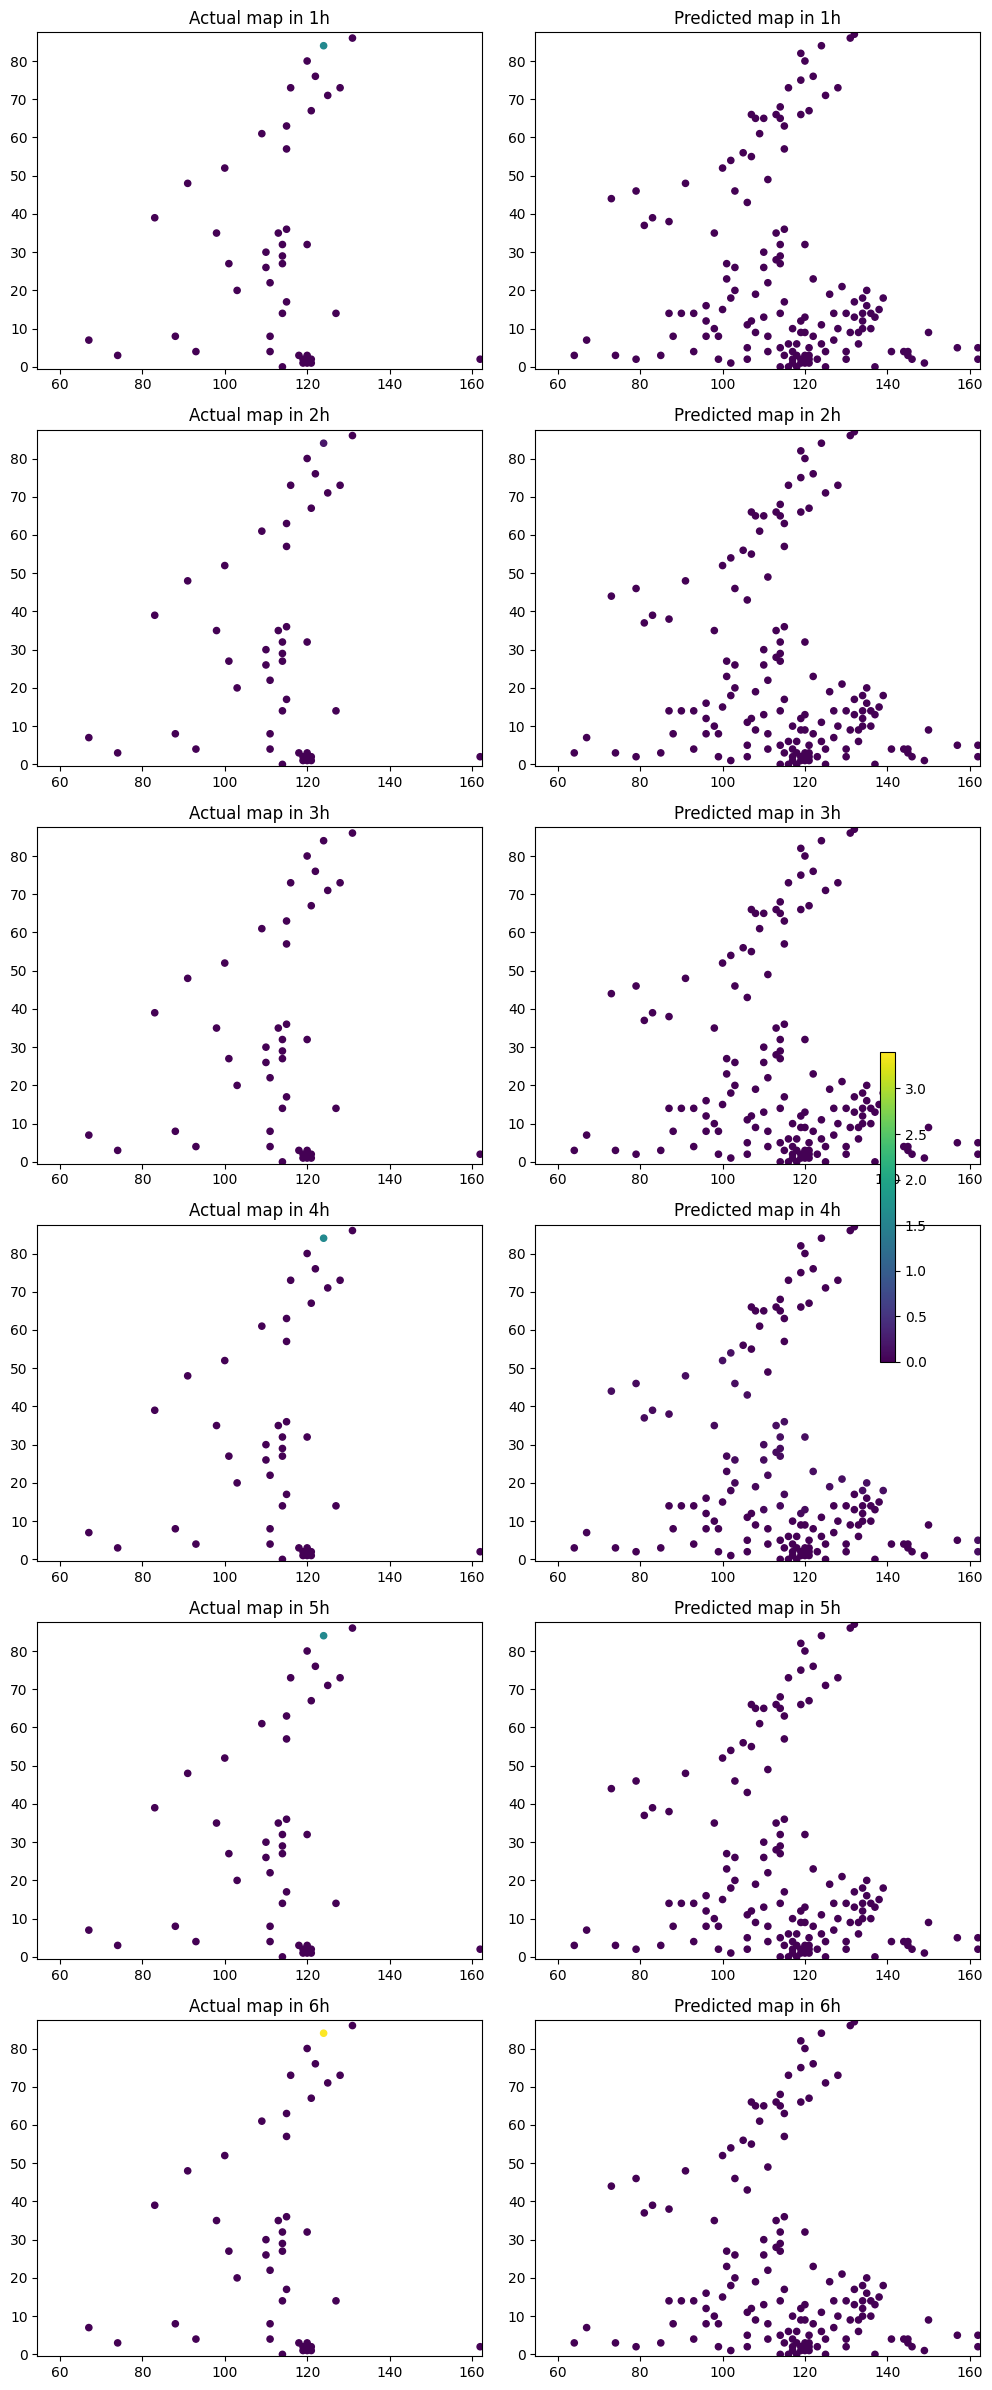

In [40]:
import matplotlib.pyplot as plt
vmin = np.nanmin(act_map)
vmax = np.nanmax(act_map)

fig, axes = plt.subplots(nrows=horizon, ncols=2, figsize=(10, 4*horizon))
for h in range(horizon):
    ax1, ax2 = axes[h]
    ax1.scatter(grid[coord_cols[1]], grid[coord_cols[0]],
                c=act_map[h], cmap='viridis', vmin=vmin, vmax=vmax, s=20)
    ax1.set_title(f'Actual map in {h+1}h')
    ax2.scatter(grid[coord_cols[1]], grid[coord_cols[0]],
                c=pred_map[h], cmap='viridis', vmin=vmin, vmax=vmax, s=20)
    ax2.set_title(f'Predicted map in {h+1}h')
    xmn, xmx = grid[coord_cols[1]].min(), grid[coord_cols[1]].max()
    ymn, ymx = grid[coord_cols[0]].min(), grid[coord_cols[0]].max()
    ax1.set_xlim(xmn-0.5, xmx+0.5);  ax1.set_ylim(ymn-0.5, ymx+0.5)
    ax2.set_xlim(xmn-0.5, xmx+0.5);  ax2.set_ylim(ymn-0.5, ymx+0.5)

fig.colorbar(axes[0,0].collections[0], ax=axes, orientation='vertical', fraction=0.02)
plt.tight_layout()
plt.show()


Test Day 2020-04-15 → RMSE=0.298, MAE=0.111, R²=-0.258


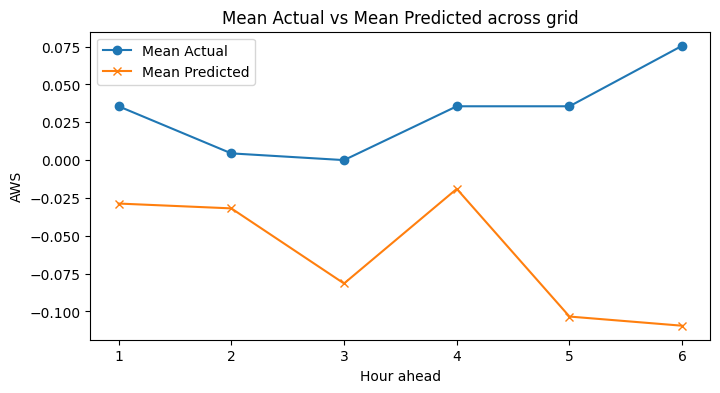

In [41]:
# Cell 11: Metrics & line chart Mean Actual vs Mean Predicted
mask = ~np.isnan(act_map) & ~np.isnan(pred_map)
all_act = act_map[mask]
all_prd = pred_map[mask]

rmse = np.sqrt(mean_squared_error(all_act, all_prd))
mae  = mean_absolute_error(all_act, all_prd)
r2   = r2_score(all_act, all_prd)
print(f"Test Day {test_day.date()} → RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")

mean_act = np.nanmean(act_map, axis=1)
mean_prd = np.nanmean(pred_map, axis=1)
hours = np.arange(1, horizon+1)

plt.figure(figsize=(8,4))
plt.plot(hours, mean_act, marker='o', label='Mean Actual')
plt.plot(hours, mean_prd, marker='x', label='Mean Predicted')
plt.xlabel('Hour ahead')
plt.ylabel('AWS')
plt.title('Mean Actual vs Mean Predicted across grid')
plt.legend()
plt.show()
